In [11]:
import ee
import pandas as pd
import json
from tqdm import tqdm

In [75]:
# Initialize Google Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-tatianauehara')

#### 1.  Data retrieval

In [76]:
with open('../data/soja_cana_tatiana_clean.geojson') as f:
    data = json.load(f)

#TDU LOOP HERE TO GET ALL FEATURES
#get first feature
feature = data['features'][0]
id = feature['properties']['id']
feature = ee.Feature(feature)
geom = feature.geometry()


In [77]:
# Defining functions
#Retrieve image collection
def retrieve_imcollection(geom):
    image_collection = ee.ImageCollection("COPERNICUS/S2") \
        .filterDate("2020-01-01", "2021-01-30") \
        .filterBounds(geom) \
        .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 20) \
        .select(["B4", "B8"])
    return image_collection

#Compute ndvi
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

#Get mean dnvi value per field and each date
def get_mean_ndvi(image):
    mean_ndvi = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=geom, scale=10)
    mean_ndvi = mean_ndvi.get('NDVI')
    return image.set('mean_ndvi', mean_ndvi)

#Get dates for pandas df
def get_dates(ndvi):
    # Get the list of image IDs
    image_ids = ndvi.aggregate_array('system:index').getInfo()

    dates = []
    # Loop through the image IDs
    for image_id in image_ids:
        # Extract the date from the image ID
        date = image_id.split('_')[1]
        date = date.split('T')[0]
        # Append the date to the list
        dates.append(date)
    
    return dates

In [96]:
# Iniciando o for loop
df_final = pd.DataFrame(columns=['month'])
df_final['month'] = range(1, 13)

for i in tqdm(range(len(data['features']))):
    feature = data['features'][i]
    id = feature['properties']['id']
    feature = ee.Feature(feature)
    geom = feature.geometry()

    print("#############################################")
    print(f"Field: {id}")

    # Get image collection
    print("1. Data collection")
    image_collection = retrieve_imcollection(geom)

    print("2. Compute NDVI and clip by geometry")
    ndvi = image_collection.map(add_ndvi)
    ndvi_clip = ndvi.map(lambda image: image.clip(geom))

    print("3. Compute mean NDVI")
    # Apply the function to each image in the collection
    ndvi_with_mean = ndvi_clip.map(get_mean_ndvi)

    ## Get the mean NDVI values
    mean_ndvi_values = ndvi_with_mean.aggregate_array('mean_ndvi').getInfo()

    print("4. Aggregate by month")
    dates = get_dates(ndvi)
    df_ndvi = pd.DataFrame({'date': dates, 'ndvi': mean_ndvi_values})

    #pandas convert date to datetime and aggregate by month
    df_ndvi['date'] = pd.to_datetime(df_ndvi['date'])
    df_ndvi['month'] = df_ndvi['date'].dt.month
    df_ndvi['year'] = df_ndvi['date'].dt.year
    
    #pandas get mean value per month
    df_ndvi_monthly = df_ndvi.groupby(['year', 'month']).mean().reset_index().drop('date', axis=1)
    df_ndvi_monthly = df_ndvi_monthly.groupby('month').mean().reset_index()
    
    #if last row is from 2021, set month as 13
    if df_ndvi_monthly['year'].iloc[-1] == 2021:
        df_ndvi_monthly['month'].iloc[-1] = 13

    # From 1 to 12, if there is a month missing, fill with information from previous month
    df_ndvi_monthly = df_ndvi_monthly.set_index('month').reindex(range(1, 14)).ffill().reset_index()

    # if month missing is the first, fill with information from next month
    df_ndvi_monthly = df_ndvi_monthly.set_index('month').reindex(range(1, 14)).bfill().reset_index()
    
    df_final[f'ndvi_{id}'] = df_ndvi_monthly['ndvi']
    print(df_final.head())
    

    

  0%|          | 0/100 [00:00<?, ?it/s]

#############################################
Field: 1
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


  1%|          | 1/100 [00:03<05:36,  3.40s/it]

   month    ndvi_1
0      1  0.845745
1      2  0.564477
2      3  0.202048
3      4  0.135616
4      5  0.165335
#############################################
Field: 2
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


  2%|▏         | 2/100 [00:07<06:09,  3.77s/it]

   month    ndvi_1    ndvi_2
0      1  0.845745  0.853356
1      2  0.564477  0.278147
2      3  0.202048  0.085578
3      4  0.135616  0.201772
4      5  0.165335  0.340284
#############################################
Field: 3
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


  3%|▎         | 3/100 [00:08<04:07,  2.55s/it]

   month    ndvi_1    ndvi_2    ndvi_3
0      1  0.845745  0.853356  0.832020
1      2  0.564477  0.278147  0.389953
2      3  0.202048  0.085578  0.149192
3      4  0.135616  0.201772  0.200414
4      5  0.165335  0.340284  0.309037
#############################################
Field: 4
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


  4%|▍         | 4/100 [00:09<03:11,  1.99s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4
0      1  0.845745  0.853356  0.832020  0.859986
1      2  0.564477  0.278147  0.389953  0.733709
2      3  0.202048  0.085578  0.149192  0.078589
3      4  0.135616  0.201772  0.200414  0.216805
4      5  0.165335  0.340284  0.309037  0.360972
#############################################
Field: 5
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


  5%|▌         | 5/100 [00:10<02:39,  1.68s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5
0      1  0.845745  0.853356  0.832020  0.859986  0.854229
1      2  0.564477  0.278147  0.389953  0.733709  0.639449
2      3  0.202048  0.085578  0.149192  0.078589  0.052957
3      4  0.135616  0.201772  0.200414  0.216805  0.277678
4      5  0.165335  0.340284  0.309037  0.360972  0.392988
#############################################
Field: 6
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


  6%|▌         | 6/100 [00:13<02:55,  1.87s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038
#############################################
Field: 7
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


  7%|▋         | 7/100 [00:21<06:22,  4.11s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6    ndvi_7
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886  0.814495
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418  0.850416
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301  0.689156
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517  0.205090
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038  0.088964
#############################################
Field: 8
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


  8%|▊         | 8/100 [00:22<04:51,  3.17s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8  
0  0.814495  0.865518  
1  0.850416  0.796159  
2  0.689156  0.132755  
3  0.205090  0.156449  
4  0.088964  0.330316  
#############################################
Field: 9
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


  9%|▉         | 9/100 [00:24<03:55,  2.59s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  
0  0.814495  0.865518  0.833718  
1  0.850416  0.796159  0.855105  
2  0.689156  0.132755  0.638075  
3  0.205090  0.156449  0.126583  
4  0.088964  0.330316  0.077361  
#############################################
Field: 10
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


 10%|█         | 10/100 [00:26<03:51,  2.58s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9   ndvi_10  
0  0.814495  0.865518  0.833718  0.826705  
1  0.850416  0.796159  0.855105  0.853231  
2  0.689156  0.132755  0.638075  0.598430  
3  0.205090  0.156449  0.126583  0.111014  
4  0.088964  0.330316  0.077361  0.068930  
#############################################
Field: 11
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


 11%|█         | 11/100 [00:31<04:45,  3.20s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9   ndvi_10   ndvi_11  
0  0.814495  0.865518  0.833718  0.826705  0.825424  
1  0.850416  0.796159  0.855105  0.853231  0.864780  
2  0.689156  0.132755  0.638075  0.598430  0.617711  
3  0.205090  0.156449  0.126583  0.111014  0.124866  
4  0.088964  0.330316  0.077361  0.068930  0.073616  
#############################################
Field: 12
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


 12%|█▏        | 12/100 [00:32<03:44,  2.56s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9   ndvi_10   ndvi_11   ndvi_12  
0  0.814495  0.865518  0.833718  0.826705  0.825424  0.829230  
1  0.850416  0.796159  0.855105  0.853231  0.864780  0.860719  
2  0.689156  0.132755  0.638075  0.598430  0.617711  0.622379  
3  0.205090  0.156449  0.126583  0.111014  0.124866  0.097387  
4  0.088964  0.330316  0.077361  0.068930  0.073616  0.068866  
#############################################
Field: 13
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute mean NDVI
4. Aggregate by month


 13%|█▎        | 13/100 [00:33<03:07,  2.15s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9   ndvi_10   ndvi_11   ndvi_12   ndvi_13  
0  0.814495  0.865518  0.833718  0.826705  0.825424  0.829230  0.823973  
1  0.850416  0.796159  0.855105  0.853231  0.864780  0.860719  0.865507  
2  0.689156  0.132755  0.638075  0.598430  0.617711  0.622379  0.626360  
3  0.205090  0.156449  0.126583  0.111014  0.124866  0.097387  0.116298  
4  0.088964  0.330316  0.077361  0.068930  0.073616  0.068866  0.067863  
#############################################
Field: 14
1. Data collection
2. Compute NDVI and clip by geometry
3. Compute 

 14%|█▍        | 14/100 [00:34<02:37,  1.83s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9   ndvi_10   ndvi_11   ndvi_12   ndvi_13  \
0  0.814495  0.865518  0.833718  0.826705  0.825424  0.829230  0.823973   
1  0.850416  0.796159  0.855105  0.853231  0.864780  0.860719  0.865507   
2  0.689156  0.132755  0.638075  0.598430  0.617711  0.622379  0.626360   
3  0.205090  0.156449  0.126583  0.111014  0.124866  0.097387  0.116298   
4  0.088964  0.330316  0.077361  0.068930  0.073616  0.068866  0.067863   

    ndvi_14  
0  0.817290  
1  0.855842  
2  0.693237  
3  0.131574  
4  0.070180  
################################

 15%|█▌        | 15/100 [00:35<02:10,  1.53s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9   ndvi_10   ndvi_11   ndvi_12   ndvi_13  \
0  0.814495  0.865518  0.833718  0.826705  0.825424  0.829230  0.823973   
1  0.850416  0.796159  0.855105  0.853231  0.864780  0.860719  0.865507   
2  0.689156  0.132755  0.638075  0.598430  0.617711  0.622379  0.626360   
3  0.205090  0.156449  0.126583  0.111014  0.124866  0.097387  0.116298   
4  0.088964  0.330316  0.077361  0.068930  0.073616  0.068866  0.067863   

    ndvi_14   ndvi_15  
0  0.817290  0.827637  
1  0.855842  0.851511  
2  0.693237  0.687369  
3  0.131574  0.14132

 16%|█▌        | 16/100 [00:36<01:57,  1.40s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9   ndvi_10   ndvi_11   ndvi_12   ndvi_13  \
0  0.814495  0.865518  0.833718  0.826705  0.825424  0.829230  0.823973   
1  0.850416  0.796159  0.855105  0.853231  0.864780  0.860719  0.865507   
2  0.689156  0.132755  0.638075  0.598430  0.617711  0.622379  0.626360   
3  0.205090  0.156449  0.126583  0.111014  0.124866  0.097387  0.116298   
4  0.088964  0.330316  0.077361  0.068930  0.073616  0.068866  0.067863   

    ndvi_14   ndvi_15   ndvi_16  
0  0.817290  0.827637  0.548401  
1  0.855842  0.851511  0.548401  
2  0.693237  0

 17%|█▋        | 17/100 [00:38<01:58,  1.42s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9   ndvi_10   ndvi_11   ndvi_12   ndvi_13  \
0  0.814495  0.865518  0.833718  0.826705  0.825424  0.829230  0.823973   
1  0.850416  0.796159  0.855105  0.853231  0.864780  0.860719  0.865507   
2  0.689156  0.132755  0.638075  0.598430  0.617711  0.622379  0.626360   
3  0.205090  0.156449  0.126583  0.111014  0.124866  0.097387  0.116298   
4  0.088964  0.330316  0.077361  0.068930  0.073616  0.068866  0.067863   

    ndvi_14   ndvi_15   ndvi_16   ndvi_17  
0  0.817290  0.827637  0.548401  0.703087  
1  0.855842  0.851511  0.548

 18%|█▊        | 18/100 [00:41<02:32,  1.85s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9   ndvi_10   ndvi_11   ndvi_12   ndvi_13  \
0  0.814495  0.865518  0.833718  0.826705  0.825424  0.829230  0.823973   
1  0.850416  0.796159  0.855105  0.853231  0.864780  0.860719  0.865507   
2  0.689156  0.132755  0.638075  0.598430  0.617711  0.622379  0.626360   
3  0.205090  0.156449  0.126583  0.111014  0.124866  0.097387  0.116298   
4  0.088964  0.330316  0.077361  0.068930  0.073616  0.068866  0.067863   

    ndvi_14   ndvi_15   ndvi_16   ndvi_17   ndvi_18  
0  0.817290  0.827637  0.548401  0.703087  0.752848  
1  0.855

 19%|█▉        | 19/100 [00:42<02:28,  1.83s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9   ndvi_10   ndvi_11   ndvi_12   ndvi_13  \
0  0.814495  0.865518  0.833718  0.826705  0.825424  0.829230  0.823973   
1  0.850416  0.796159  0.855105  0.853231  0.864780  0.860719  0.865507   
2  0.689156  0.132755  0.638075  0.598430  0.617711  0.622379  0.626360   
3  0.205090  0.156449  0.126583  0.111014  0.124866  0.097387  0.116298   
4  0.088964  0.330316  0.077361  0.068930  0.073616  0.068866  0.067863   

    ndvi_14   ndvi_15   ndvi_16   ndvi_17   ndvi_18   ndvi_19  
0  0.817290  0.827637  0.548401  0.703087  0.752848 

 20%|██        | 20/100 [00:44<02:34,  1.93s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_11   ndvi_12   ndvi_13   ndvi_14  \
0  0.814495  0.865518  0.833718  ...  0.825424  0.829230  0.823973  0.817290   
1  0.850416  0.796159  0.855105  ...  0.864780  0.860719  0.865507  0.855842   
2  0.689156  0.132755  0.638075  ...  0.617711  0.622379  0.626360  0.693237   
3  0.205090  0.156449  0.126583  ...  0.124866  0.097387  0.116298  0.131574   
4  0.088964  0.330316  0.077361  ...  0.073616  0.068866  0.067863  0.070180   

    ndvi_15   ndvi_16   ndvi_17   ndvi_18   ndvi_19   ndvi_20  
0  0.827637  0.548401 

 21%|██        | 21/100 [00:46<02:15,  1.71s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_12   ndvi_13   ndvi_14   ndvi_15  \
0  0.814495  0.865518  0.833718  ...  0.829230  0.823973  0.817290  0.827637   
1  0.850416  0.796159  0.855105  ...  0.860719  0.865507  0.855842  0.851511   
2  0.689156  0.132755  0.638075  ...  0.622379  0.626360  0.693237  0.687369   
3  0.205090  0.156449  0.126583  ...  0.097387  0.116298  0.131574  0.141325   
4  0.088964  0.330316  0.077361  ...  0.068866  0.067863  0.070180  0.071831   

    ndvi_16   ndvi_17   ndvi_18   ndvi_19   ndvi_20   ndvi_21  
0  0.548401  0.703087 

 22%|██▏       | 22/100 [00:47<02:03,  1.58s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_13   ndvi_14   ndvi_15   ndvi_16  \
0  0.814495  0.865518  0.833718  ...  0.823973  0.817290  0.827637  0.548401   
1  0.850416  0.796159  0.855105  ...  0.865507  0.855842  0.851511  0.548401   
2  0.689156  0.132755  0.638075  ...  0.626360  0.693237  0.687369  0.217056   
3  0.205090  0.156449  0.126583  ...  0.116298  0.131574  0.141325  0.133408   
4  0.088964  0.330316  0.077361  ...  0.067863  0.070180  0.071831  0.186492   

    ndvi_17   ndvi_18   ndvi_19   ndvi_20   ndvi_21   ndvi_22  
0  0.703087  0.752848 

 23%|██▎       | 23/100 [00:50<02:31,  1.97s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_14   ndvi_15   ndvi_16   ndvi_17  \
0  0.814495  0.865518  0.833718  ...  0.817290  0.827637  0.548401  0.703087   
1  0.850416  0.796159  0.855105  ...  0.855842  0.851511  0.548401  0.703087   
2  0.689156  0.132755  0.638075  ...  0.693237  0.687369  0.217056  0.181832   
3  0.205090  0.156449  0.126583  ...  0.131574  0.141325  0.133408  0.111347   
4  0.088964  0.330316  0.077361  ...  0.070180  0.071831  0.186492  0.196219   

    ndvi_18   ndvi_19   ndvi_20   ndvi_21   ndvi_22   ndvi_23  
0  0.752848  0.756549 

 24%|██▍       | 24/100 [00:51<02:17,  1.81s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_15   ndvi_16   ndvi_17   ndvi_18  \
0  0.814495  0.865518  0.833718  ...  0.827637  0.548401  0.703087  0.752848   
1  0.850416  0.796159  0.855105  ...  0.851511  0.548401  0.703087  0.752848   
2  0.689156  0.132755  0.638075  ...  0.687369  0.217056  0.181832  0.219210   
3  0.205090  0.156449  0.126583  ...  0.141325  0.133408  0.111347  0.132405   
4  0.088964  0.330316  0.077361  ...  0.071831  0.186492  0.196219  0.178987   

    ndvi_19   ndvi_20   ndvi_21   ndvi_22   ndvi_23   ndvi_24  
0  0.756549  0.802871 

 25%|██▌       | 25/100 [00:55<03:00,  2.41s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_16   ndvi_17   ndvi_18   ndvi_19  \
0  0.814495  0.865518  0.833718  ...  0.548401  0.703087  0.752848  0.756549   
1  0.850416  0.796159  0.855105  ...  0.548401  0.703087  0.752848  0.756549   
2  0.689156  0.132755  0.638075  ...  0.217056  0.181832  0.219210  0.199936   
3  0.205090  0.156449  0.126583  ...  0.133408  0.111347  0.132405  0.132931   
4  0.088964  0.330316  0.077361  ...  0.186492  0.196219  0.178987  0.196670   

    ndvi_20   ndvi_21   ndvi_22   ndvi_23   ndvi_24   ndvi_25  
0  0.802871  0.793491 

 26%|██▌       | 26/100 [00:57<02:37,  2.13s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_17   ndvi_18   ndvi_19   ndvi_20  \
0  0.814495  0.865518  0.833718  ...  0.703087  0.752848  0.756549  0.802871   
1  0.850416  0.796159  0.855105  ...  0.703087  0.752848  0.756549  0.802871   
2  0.689156  0.132755  0.638075  ...  0.181832  0.219210  0.199936  0.246958   
3  0.205090  0.156449  0.126583  ...  0.111347  0.132405  0.132931  0.201279   
4  0.088964  0.330316  0.077361  ...  0.196219  0.178987  0.196670  0.324117   

    ndvi_21   ndvi_22   ndvi_23   ndvi_24   ndvi_25   ndvi_26  
0  0.793491  0.780408 

 27%|██▋       | 27/100 [00:58<02:29,  2.05s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_18   ndvi_19   ndvi_20   ndvi_21  \
0  0.814495  0.865518  0.833718  ...  0.752848  0.756549  0.802871  0.793491   
1  0.850416  0.796159  0.855105  ...  0.752848  0.756549  0.802871  0.793491   
2  0.689156  0.132755  0.638075  ...  0.219210  0.199936  0.246958  0.199942   
3  0.205090  0.156449  0.126583  ...  0.132405  0.132931  0.201279  0.188902   
4  0.088964  0.330316  0.077361  ...  0.178987  0.196670  0.324117  0.293898   

    ndvi_22   ndvi_23   ndvi_24   ndvi_25   ndvi_26   ndvi_27  
0  0.780408  0.769771 

 28%|██▊       | 28/100 [01:00<02:09,  1.80s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_19   ndvi_20   ndvi_21   ndvi_22  \
0  0.814495  0.865518  0.833718  ...  0.756549  0.802871  0.793491  0.780408   
1  0.850416  0.796159  0.855105  ...  0.756549  0.802871  0.793491  0.780408   
2  0.689156  0.132755  0.638075  ...  0.199936  0.246958  0.199942  0.208854   
3  0.205090  0.156449  0.126583  ...  0.132931  0.201279  0.188902  0.212244   
4  0.088964  0.330316  0.077361  ...  0.196670  0.324117  0.293898  0.302139   

    ndvi_23   ndvi_24   ndvi_25   ndvi_26   ndvi_27   ndvi_28  
0  0.769771  0.779864 

 29%|██▉       | 29/100 [01:01<01:50,  1.56s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_20   ndvi_21   ndvi_22   ndvi_23  \
0  0.814495  0.865518  0.833718  ...  0.802871  0.793491  0.780408  0.769771   
1  0.850416  0.796159  0.855105  ...  0.802871  0.793491  0.780408  0.769771   
2  0.689156  0.132755  0.638075  ...  0.246958  0.199942  0.208854  0.220380   
3  0.205090  0.156449  0.126583  ...  0.201279  0.188902  0.212244  0.209059   
4  0.088964  0.330316  0.077361  ...  0.324117  0.293898  0.302139  0.314028   

    ndvi_24   ndvi_25   ndvi_26   ndvi_27   ndvi_28   ndvi_29  
0  0.779864  0.554610 

 30%|███       | 30/100 [01:02<01:42,  1.46s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_21   ndvi_22   ndvi_23   ndvi_24  \
0  0.814495  0.865518  0.833718  ...  0.793491  0.780408  0.769771  0.779864   
1  0.850416  0.796159  0.855105  ...  0.793491  0.780408  0.769771  0.779864   
2  0.689156  0.132755  0.638075  ...  0.199942  0.208854  0.220380  0.216627   
3  0.205090  0.156449  0.126583  ...  0.188902  0.212244  0.209059  0.212064   
4  0.088964  0.330316  0.077361  ...  0.293898  0.302139  0.314028  0.317325   

    ndvi_25   ndvi_26   ndvi_27   ndvi_28   ndvi_29   ndvi_30  
0  0.554610  0.661557 

 31%|███       | 31/100 [01:09<03:29,  3.04s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_22   ndvi_23   ndvi_24   ndvi_25  \
0  0.814495  0.865518  0.833718  ...  0.780408  0.769771  0.779864  0.554610   
1  0.850416  0.796159  0.855105  ...  0.780408  0.769771  0.779864  0.554610   
2  0.689156  0.132755  0.638075  ...  0.208854  0.220380  0.216627  0.169173   
3  0.205090  0.156449  0.126583  ...  0.212244  0.209059  0.212064  0.160650   
4  0.088964  0.330316  0.077361  ...  0.302139  0.314028  0.317325  0.178540   

    ndvi_26   ndvi_27   ndvi_28   ndvi_29   ndvi_30   ndvi_31  
0  0.661557  0.758208 

 32%|███▏      | 32/100 [01:10<02:44,  2.41s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_23   ndvi_24   ndvi_25   ndvi_26  \
0  0.814495  0.865518  0.833718  ...  0.769771  0.779864  0.554610  0.661557   
1  0.850416  0.796159  0.855105  ...  0.769771  0.779864  0.554610  0.846923   
2  0.689156  0.132755  0.638075  ...  0.220380  0.216627  0.169173  0.733162   
3  0.205090  0.156449  0.126583  ...  0.209059  0.212064  0.160650  0.285667   
4  0.088964  0.330316  0.077361  ...  0.314028  0.317325  0.178540  0.136946   

    ndvi_27   ndvi_28   ndvi_29   ndvi_30   ndvi_31   ndvi_32  
0  0.758208  0.503893 

 33%|███▎      | 33/100 [01:10<02:10,  1.95s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_24   ndvi_25   ndvi_26   ndvi_27  \
0  0.814495  0.865518  0.833718  ...  0.779864  0.554610  0.661557  0.758208   
1  0.850416  0.796159  0.855105  ...  0.779864  0.554610  0.846923  0.846666   
2  0.689156  0.132755  0.638075  ...  0.216627  0.169173  0.733162  0.676463   
3  0.205090  0.156449  0.126583  ...  0.212064  0.160650  0.285667  0.158444   
4  0.088964  0.330316  0.077361  ...  0.317325  0.178540  0.136946  0.110905   

    ndvi_28   ndvi_29   ndvi_30   ndvi_31   ndvi_32   ndvi_33  
0  0.503893  0.719697 

 34%|███▍      | 34/100 [01:11<01:46,  1.62s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_25   ndvi_26   ndvi_27   ndvi_28  \
0  0.814495  0.865518  0.833718  ...  0.554610  0.661557  0.758208  0.503893   
1  0.850416  0.796159  0.855105  ...  0.554610  0.846923  0.846666  0.702193   
2  0.689156  0.132755  0.638075  ...  0.169173  0.733162  0.676463  0.301514   
3  0.205090  0.156449  0.126583  ...  0.160650  0.285667  0.158444  0.143182   
4  0.088964  0.330316  0.077361  ...  0.178540  0.136946  0.110905  0.209088   

    ndvi_29   ndvi_30   ndvi_31   ndvi_32   ndvi_33   ndvi_34  
0  0.719697  0.757566 

 35%|███▌      | 35/100 [01:13<01:38,  1.52s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_26   ndvi_27   ndvi_28   ndvi_29  \
0  0.814495  0.865518  0.833718  ...  0.661557  0.758208  0.503893  0.719697   
1  0.850416  0.796159  0.855105  ...  0.846923  0.846666  0.702193  0.734072   
2  0.689156  0.132755  0.638075  ...  0.733162  0.676463  0.301514  0.604177   
3  0.205090  0.156449  0.126583  ...  0.285667  0.158444  0.143182  0.060904   
4  0.088964  0.330316  0.077361  ...  0.136946  0.110905  0.209088  0.127540   

    ndvi_30   ndvi_31   ndvi_32   ndvi_33   ndvi_34   ndvi_35  
0  0.757566  0.522807 

 36%|███▌      | 36/100 [01:19<03:06,  2.92s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_27   ndvi_28   ndvi_29   ndvi_30  \
0  0.814495  0.865518  0.833718  ...  0.758208  0.503893  0.719697  0.757566   
1  0.850416  0.796159  0.855105  ...  0.846666  0.702193  0.734072  0.785196   
2  0.689156  0.132755  0.638075  ...  0.676463  0.301514  0.604177  0.599098   
3  0.205090  0.156449  0.126583  ...  0.158444  0.143182  0.060904  0.071346   
4  0.088964  0.330316  0.077361  ...  0.110905  0.209088  0.127540  0.191272   

    ndvi_31   ndvi_32   ndvi_33   ndvi_34   ndvi_35   ndvi_36  
0  0.522807  0.632563 

 37%|███▋      | 37/100 [01:20<02:31,  2.40s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_28   ndvi_29   ndvi_30   ndvi_31  \
0  0.814495  0.865518  0.833718  ...  0.503893  0.719697  0.757566  0.522807   
1  0.850416  0.796159  0.855105  ...  0.702193  0.734072  0.785196  0.737522   
2  0.689156  0.132755  0.638075  ...  0.301514  0.604177  0.599098  0.401611   
3  0.205090  0.156449  0.126583  ...  0.143182  0.060904  0.071346  0.154265   
4  0.088964  0.330316  0.077361  ...  0.209088  0.127540  0.191272  0.231039   

    ndvi_32   ndvi_33   ndvi_34   ndvi_35   ndvi_36   ndvi_37  
0  0.632563  0.650583 

 38%|███▊      | 38/100 [01:22<02:13,  2.16s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_29   ndvi_30   ndvi_31   ndvi_32  \
0  0.814495  0.865518  0.833718  ...  0.719697  0.757566  0.522807  0.632563   
1  0.850416  0.796159  0.855105  ...  0.734072  0.785196  0.737522  0.511845   
2  0.689156  0.132755  0.638075  ...  0.604177  0.599098  0.401611  0.172838   
3  0.205090  0.156449  0.126583  ...  0.060904  0.071346  0.154265  0.194785   
4  0.088964  0.330316  0.077361  ...  0.127540  0.191272  0.231039  0.235827   

    ndvi_33   ndvi_34   ndvi_35   ndvi_36   ndvi_37   ndvi_38  
0  0.650583  0.773555 

 39%|███▉      | 39/100 [01:23<01:58,  1.95s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_30   ndvi_31   ndvi_32   ndvi_33  \
0  0.814495  0.865518  0.833718  ...  0.757566  0.522807  0.632563  0.650583   
1  0.850416  0.796159  0.855105  ...  0.785196  0.737522  0.511845  0.589729   
2  0.689156  0.132755  0.638075  ...  0.599098  0.401611  0.172838  0.166910   
3  0.205090  0.156449  0.126583  ...  0.071346  0.154265  0.194785  0.165310   
4  0.088964  0.330316  0.077361  ...  0.191272  0.231039  0.235827  0.215739   

    ndvi_34   ndvi_35   ndvi_36   ndvi_37   ndvi_38   ndvi_39  
0  0.773555  0.716801 

 40%|████      | 40/100 [01:24<01:40,  1.67s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_31   ndvi_32   ndvi_33   ndvi_34  \
0  0.814495  0.865518  0.833718  ...  0.522807  0.632563  0.650583  0.773555   
1  0.850416  0.796159  0.855105  ...  0.737522  0.511845  0.589729  0.479172   
2  0.689156  0.132755  0.638075  ...  0.401611  0.172838  0.166910  0.182109   
3  0.205090  0.156449  0.126583  ...  0.154265  0.194785  0.165310  0.170888   
4  0.088964  0.330316  0.077361  ...  0.231039  0.235827  0.215739  0.227042   

    ndvi_35   ndvi_36   ndvi_37   ndvi_38   ndvi_39   ndvi_40  
0  0.716801  0.778628 

 41%|████      | 41/100 [01:25<01:26,  1.47s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_32   ndvi_33   ndvi_34   ndvi_35  \
0  0.814495  0.865518  0.833718  ...  0.632563  0.650583  0.773555  0.716801   
1  0.850416  0.796159  0.855105  ...  0.511845  0.589729  0.479172  0.450485   
2  0.689156  0.132755  0.638075  ...  0.172838  0.166910  0.182109  0.226910   
3  0.205090  0.156449  0.126583  ...  0.194785  0.165310  0.170888  0.396028   
4  0.088964  0.330316  0.077361  ...  0.235827  0.215739  0.227042  0.367850   

    ndvi_36   ndvi_37   ndvi_38   ndvi_39   ndvi_40   ndvi_41  
0  0.778628  0.761841 

 42%|████▏     | 42/100 [01:26<01:15,  1.30s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_33   ndvi_34   ndvi_35   ndvi_36  \
0  0.814495  0.865518  0.833718  ...  0.650583  0.773555  0.716801  0.778628   
1  0.850416  0.796159  0.855105  ...  0.589729  0.479172  0.450485  0.455891   
2  0.689156  0.132755  0.638075  ...  0.166910  0.182109  0.226910  0.195026   
3  0.205090  0.156449  0.126583  ...  0.165310  0.170888  0.396028  0.198339   
4  0.088964  0.330316  0.077361  ...  0.215739  0.227042  0.367850  0.276008   

    ndvi_37   ndvi_38   ndvi_39   ndvi_40   ndvi_41   ndvi_42  
0  0.761841  0.585182 

 43%|████▎     | 43/100 [01:33<02:49,  2.97s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_34   ndvi_35   ndvi_36   ndvi_37  \
0  0.814495  0.865518  0.833718  ...  0.773555  0.716801  0.778628  0.761841   
1  0.850416  0.796159  0.855105  ...  0.479172  0.450485  0.455891  0.535209   
2  0.689156  0.132755  0.638075  ...  0.182109  0.226910  0.195026  0.188261   
3  0.205090  0.156449  0.126583  ...  0.170888  0.396028  0.198339  0.334930   
4  0.088964  0.330316  0.077361  ...  0.227042  0.367850  0.276008  0.408524   

    ndvi_38   ndvi_39   ndvi_40   ndvi_41   ndvi_42   ndvi_43  
0  0.585182  0.584802 

 44%|████▍     | 44/100 [01:41<04:14,  4.54s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_35   ndvi_36   ndvi_37   ndvi_38  \
0  0.814495  0.865518  0.833718  ...  0.716801  0.778628  0.761841  0.585182   
1  0.850416  0.796159  0.855105  ...  0.450485  0.455891  0.535209  0.851860   
2  0.689156  0.132755  0.638075  ...  0.226910  0.195026  0.188261  0.642815   
3  0.205090  0.156449  0.126583  ...  0.396028  0.198339  0.334930  0.168809   
4  0.088964  0.330316  0.077361  ...  0.367850  0.276008  0.408524  0.146663   

    ndvi_39   ndvi_40   ndvi_41   ndvi_42   ndvi_43   ndvi_44  
0  0.584802  0.565591 

 45%|████▌     | 45/100 [01:43<03:32,  3.86s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_36   ndvi_37   ndvi_38   ndvi_39  \
0  0.814495  0.865518  0.833718  ...  0.778628  0.761841  0.585182  0.584802   
1  0.850416  0.796159  0.855105  ...  0.455891  0.535209  0.851860  0.848966   
2  0.689156  0.132755  0.638075  ...  0.195026  0.188261  0.642815  0.650134   
3  0.205090  0.156449  0.126583  ...  0.198339  0.334930  0.168809  0.175993   
4  0.088964  0.330316  0.077361  ...  0.276008  0.408524  0.146663  0.155562   

    ndvi_40   ndvi_41   ndvi_42   ndvi_43   ndvi_44   ndvi_45  
0  0.565591  0.585971 

 46%|████▌     | 46/100 [01:44<02:45,  3.07s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_37   ndvi_38   ndvi_39   ndvi_40  \
0  0.814495  0.865518  0.833718  ...  0.761841  0.585182  0.584802  0.565591   
1  0.850416  0.796159  0.855105  ...  0.535209  0.851860  0.848966  0.847646   
2  0.689156  0.132755  0.638075  ...  0.188261  0.642815  0.650134  0.644987   
3  0.205090  0.156449  0.126583  ...  0.334930  0.168809  0.175993  0.158114   
4  0.088964  0.330316  0.077361  ...  0.408524  0.146663  0.155562  0.143368   

    ndvi_41   ndvi_42   ndvi_43   ndvi_44   ndvi_45   ndvi_46  
0  0.585971  0.809744 

 47%|████▋     | 47/100 [01:48<02:44,  3.11s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_38   ndvi_39   ndvi_40   ndvi_41  \
0  0.814495  0.865518  0.833718  ...  0.585182  0.584802  0.565591  0.585971   
1  0.850416  0.796159  0.855105  ...  0.851860  0.848966  0.847646  0.849339   
2  0.689156  0.132755  0.638075  ...  0.642815  0.650134  0.644987  0.650654   
3  0.205090  0.156449  0.126583  ...  0.168809  0.175993  0.158114  0.175064   
4  0.088964  0.330316  0.077361  ...  0.146663  0.155562  0.143368  0.151395   

    ndvi_42   ndvi_43   ndvi_44   ndvi_45   ndvi_46   ndvi_47  
0  0.809744  0.782803 

 48%|████▊     | 48/100 [01:51<02:52,  3.31s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_39   ndvi_40   ndvi_41   ndvi_42  \
0  0.814495  0.865518  0.833718  ...  0.584802  0.565591  0.585971  0.809744   
1  0.850416  0.796159  0.855105  ...  0.848966  0.847646  0.849339  0.863024   
2  0.689156  0.132755  0.638075  ...  0.650134  0.644987  0.650654  0.469970   
3  0.205090  0.156449  0.126583  ...  0.175993  0.158114  0.175064  0.218122   
4  0.088964  0.330316  0.077361  ...  0.155562  0.143368  0.151395  0.326954   

    ndvi_43   ndvi_44   ndvi_45   ndvi_46   ndvi_47   ndvi_48  
0  0.782803  0.806122 

 49%|████▉     | 49/100 [01:53<02:18,  2.72s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_40   ndvi_41   ndvi_42   ndvi_43  \
0  0.814495  0.865518  0.833718  ...  0.565591  0.585971  0.809744  0.782803   
1  0.850416  0.796159  0.855105  ...  0.847646  0.849339  0.863024  0.860835   
2  0.689156  0.132755  0.638075  ...  0.644987  0.650654  0.469970  0.289302   
3  0.205090  0.156449  0.126583  ...  0.158114  0.175064  0.218122  0.266729   
4  0.088964  0.330316  0.077361  ...  0.143368  0.151395  0.326954  0.337068   

    ndvi_44   ndvi_45   ndvi_46   ndvi_47   ndvi_48   ndvi_49  
0  0.806122  0.794400 

 50%|█████     | 50/100 [01:54<02:00,  2.40s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_41   ndvi_42   ndvi_43   ndvi_44  \
0  0.814495  0.865518  0.833718  ...  0.585971  0.809744  0.782803  0.806122   
1  0.850416  0.796159  0.855105  ...  0.849339  0.863024  0.860835  0.860627   
2  0.689156  0.132755  0.638075  ...  0.650654  0.469970  0.289302  0.473146   
3  0.205090  0.156449  0.126583  ...  0.175064  0.218122  0.266729  0.230086   
4  0.088964  0.330316  0.077361  ...  0.151395  0.326954  0.337068  0.368987   

    ndvi_45   ndvi_46   ndvi_47   ndvi_48   ndvi_49   ndvi_50  
0  0.794400  0.762508 

 51%|█████     | 51/100 [01:56<01:40,  2.06s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_42   ndvi_43   ndvi_44   ndvi_45  \
0  0.814495  0.865518  0.833718  ...  0.809744  0.782803  0.806122  0.794400   
1  0.850416  0.796159  0.855105  ...  0.863024  0.860835  0.860627  0.860624   
2  0.689156  0.132755  0.638075  ...  0.469970  0.289302  0.473146  0.686655   
3  0.205090  0.156449  0.126583  ...  0.218122  0.266729  0.230086  0.184590   
4  0.088964  0.330316  0.077361  ...  0.326954  0.337068  0.368987  0.279250   

    ndvi_46   ndvi_47   ndvi_48   ndvi_49   ndvi_50   ndvi_51  
0  0.762508  0.792106 

 52%|█████▏    | 52/100 [01:58<01:39,  2.08s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_43   ndvi_44   ndvi_45   ndvi_46  \
0  0.814495  0.865518  0.833718  ...  0.782803  0.806122  0.794400  0.762508   
1  0.850416  0.796159  0.855105  ...  0.860835  0.860627  0.860624  0.858506   
2  0.689156  0.132755  0.638075  ...  0.289302  0.473146  0.686655  0.660662   
3  0.205090  0.156449  0.126583  ...  0.266729  0.230086  0.184590  0.264871   
4  0.088964  0.330316  0.077361  ...  0.337068  0.368987  0.279250  0.144128   

    ndvi_47   ndvi_48   ndvi_49   ndvi_50   ndvi_51   ndvi_52  
0  0.792106  0.807698 

 53%|█████▎    | 53/100 [02:04<02:35,  3.31s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_44   ndvi_45   ndvi_46   ndvi_47  \
0  0.814495  0.865518  0.833718  ...  0.806122  0.794400  0.762508  0.792106   
1  0.850416  0.796159  0.855105  ...  0.860627  0.860624  0.858506  0.861391   
2  0.689156  0.132755  0.638075  ...  0.473146  0.686655  0.660662  0.656246   
3  0.205090  0.156449  0.126583  ...  0.230086  0.184590  0.264871  0.182601   
4  0.088964  0.330316  0.077361  ...  0.368987  0.279250  0.144128  0.166220   

    ndvi_48   ndvi_49   ndvi_50   ndvi_51   ndvi_52   ndvi_53  
0  0.807698  0.724100 

 54%|█████▍    | 54/100 [02:12<03:33,  4.65s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_45   ndvi_46   ndvi_47   ndvi_48  \
0  0.814495  0.865518  0.833718  ...  0.794400  0.762508  0.792106  0.807698   
1  0.850416  0.796159  0.855105  ...  0.860624  0.858506  0.861391  0.863921   
2  0.689156  0.132755  0.638075  ...  0.686655  0.660662  0.656246  0.313310   
3  0.205090  0.156449  0.126583  ...  0.184590  0.264871  0.182601  0.190465   
4  0.088964  0.330316  0.077361  ...  0.279250  0.144128  0.166220  0.339589   

    ndvi_49   ndvi_50   ndvi_51   ndvi_52   ndvi_53   ndvi_54  
0  0.724100  0.763574 

 55%|█████▌    | 55/100 [02:14<02:56,  3.93s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_46   ndvi_47   ndvi_48   ndvi_49  \
0  0.814495  0.865518  0.833718  ...  0.762508  0.792106  0.807698  0.724100   
1  0.850416  0.796159  0.855105  ...  0.858506  0.861391  0.863921  0.792963   
2  0.689156  0.132755  0.638075  ...  0.660662  0.656246  0.313310  0.244758   
3  0.205090  0.156449  0.126583  ...  0.264871  0.182601  0.190465  0.110133   
4  0.088964  0.330316  0.077361  ...  0.144128  0.166220  0.339589  0.186518   

    ndvi_50   ndvi_51   ndvi_52   ndvi_53   ndvi_54   ndvi_55  
0  0.763574  0.660966 

 56%|█████▌    | 56/100 [02:16<02:23,  3.25s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_47   ndvi_48   ndvi_49   ndvi_50  \
0  0.814495  0.865518  0.833718  ...  0.792106  0.807698  0.724100  0.763574   
1  0.850416  0.796159  0.855105  ...  0.861391  0.863921  0.792963  0.790683   
2  0.689156  0.132755  0.638075  ...  0.656246  0.313310  0.244758  0.242874   
3  0.205090  0.156449  0.126583  ...  0.182601  0.190465  0.110133  0.125287   
4  0.088964  0.330316  0.077361  ...  0.166220  0.339589  0.186518  0.156676   

    ndvi_51   ndvi_52   ndvi_53   ndvi_54   ndvi_55   ndvi_56  
0  0.660966  0.635336 

 57%|█████▋    | 57/100 [02:22<03:03,  4.27s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_48   ndvi_49   ndvi_50   ndvi_51  \
0  0.814495  0.865518  0.833718  ...  0.807698  0.724100  0.763574  0.660966   
1  0.850416  0.796159  0.855105  ...  0.863921  0.792963  0.790683  0.556861   
2  0.689156  0.132755  0.638075  ...  0.313310  0.244758  0.242874  0.625786   
3  0.205090  0.156449  0.126583  ...  0.190465  0.110133  0.125287  0.622651   
4  0.088964  0.330316  0.077361  ...  0.339589  0.186518  0.156676  0.566390   

    ndvi_52   ndvi_53   ndvi_54   ndvi_55   ndvi_56   ndvi_57  
0  0.635336  0.680108 

 58%|█████▊    | 58/100 [02:23<02:17,  3.26s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_49   ndvi_50   ndvi_51   ndvi_52  \
0  0.814495  0.865518  0.833718  ...  0.724100  0.763574  0.660966  0.635336   
1  0.850416  0.796159  0.855105  ...  0.792963  0.790683  0.556861  0.583502   
2  0.689156  0.132755  0.638075  ...  0.244758  0.242874  0.625786  0.630845   
3  0.205090  0.156449  0.126583  ...  0.110133  0.125287  0.622651  0.628038   
4  0.088964  0.330316  0.077361  ...  0.186518  0.156676  0.566390  0.569383   

    ndvi_53   ndvi_54   ndvi_55   ndvi_56   ndvi_57   ndvi_58  
0  0.680108  0.533011 

 59%|█████▉    | 59/100 [02:31<03:05,  4.53s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_50   ndvi_51   ndvi_52   ndvi_53  \
0  0.814495  0.865518  0.833718  ...  0.763574  0.660966  0.635336  0.680108   
1  0.850416  0.796159  0.855105  ...  0.790683  0.556861  0.583502  0.544735   
2  0.689156  0.132755  0.638075  ...  0.242874  0.625786  0.630845  0.703769   
3  0.205090  0.156449  0.126583  ...  0.125287  0.622651  0.628038  0.708450   
4  0.088964  0.330316  0.077361  ...  0.156676  0.566390  0.569383  0.683289   

    ndvi_54   ndvi_55   ndvi_56   ndvi_57   ndvi_58   ndvi_59  
0  0.533011  0.512990 

 60%|██████    | 60/100 [02:32<02:20,  3.51s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_51   ndvi_52   ndvi_53   ndvi_54  \
0  0.814495  0.865518  0.833718  ...  0.660966  0.635336  0.680108  0.533011   
1  0.850416  0.796159  0.855105  ...  0.556861  0.583502  0.544735  0.457731   
2  0.689156  0.132755  0.638075  ...  0.625786  0.630845  0.703769  0.586968   
3  0.205090  0.156449  0.126583  ...  0.622651  0.628038  0.708450  0.594330   
4  0.088964  0.330316  0.077361  ...  0.566390  0.569383  0.683289  0.542360   

    ndvi_55   ndvi_56   ndvi_57   ndvi_58   ndvi_59   ndvi_60  
0  0.512990  0.612192 

 61%|██████    | 61/100 [02:38<02:52,  4.41s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_52   ndvi_53   ndvi_54   ndvi_55  \
0  0.814495  0.865518  0.833718  ...  0.635336  0.680108  0.533011  0.512990   
1  0.850416  0.796159  0.855105  ...  0.583502  0.544735  0.457731  0.492724   
2  0.689156  0.132755  0.638075  ...  0.630845  0.703769  0.586968  0.501925   
3  0.205090  0.156449  0.126583  ...  0.628038  0.708450  0.594330  0.515900   
4  0.088964  0.330316  0.077361  ...  0.569383  0.683289  0.542360  0.458851   

    ndvi_56   ndvi_57   ndvi_58   ndvi_59   ndvi_60   ndvi_61  
0  0.612192  0.675100 

 62%|██████▏   | 62/100 [02:40<02:17,  3.62s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_53   ndvi_54   ndvi_55   ndvi_56  \
0  0.814495  0.865518  0.833718  ...  0.680108  0.533011  0.512990  0.612192   
1  0.850416  0.796159  0.855105  ...  0.544735  0.457731  0.492724  0.655217   
2  0.689156  0.132755  0.638075  ...  0.703769  0.586968  0.501925  0.685712   
3  0.205090  0.156449  0.126583  ...  0.708450  0.594330  0.515900  0.702346   
4  0.088964  0.330316  0.077361  ...  0.683289  0.542360  0.458851  0.631615   

    ndvi_57   ndvi_58   ndvi_59   ndvi_60   ndvi_61   ndvi_62  
0  0.675100  0.603537 

 63%|██████▎   | 63/100 [02:41<01:45,  2.85s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_54   ndvi_55   ndvi_56   ndvi_57  \
0  0.814495  0.865518  0.833718  ...  0.533011  0.512990  0.612192  0.675100   
1  0.850416  0.796159  0.855105  ...  0.457731  0.492724  0.655217  0.685069   
2  0.689156  0.132755  0.638075  ...  0.586968  0.501925  0.685712  0.724980   
3  0.205090  0.156449  0.126583  ...  0.594330  0.515900  0.702346  0.707834   
4  0.088964  0.330316  0.077361  ...  0.542360  0.458851  0.631615  0.197296   

    ndvi_58   ndvi_59   ndvi_60   ndvi_61   ndvi_62   ndvi_63  
0  0.603537  0.655050 

 64%|██████▍   | 64/100 [02:48<02:24,  4.00s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_55   ndvi_56   ndvi_57   ndvi_58  \
0  0.814495  0.865518  0.833718  ...  0.512990  0.612192  0.675100  0.603537   
1  0.850416  0.796159  0.855105  ...  0.492724  0.655217  0.685069  0.622972   
2  0.689156  0.132755  0.638075  ...  0.501925  0.685712  0.724980  0.496145   
3  0.205090  0.156449  0.126583  ...  0.515900  0.702346  0.707834  0.198652   
4  0.088964  0.330316  0.077361  ...  0.458851  0.631615  0.197296  0.208534   

    ndvi_59   ndvi_60   ndvi_61   ndvi_62   ndvi_63   ndvi_64  
0  0.655050  0.651554 

 65%|██████▌   | 65/100 [02:49<01:53,  3.25s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_56   ndvi_57   ndvi_58   ndvi_59  \
0  0.814495  0.865518  0.833718  ...  0.612192  0.675100  0.603537  0.655050   
1  0.850416  0.796159  0.855105  ...  0.655217  0.685069  0.622972  0.677407   
2  0.689156  0.132755  0.638075  ...  0.685712  0.724980  0.496145  0.574523   
3  0.205090  0.156449  0.126583  ...  0.702346  0.707834  0.198652  0.481662   
4  0.088964  0.330316  0.077361  ...  0.631615  0.197296  0.208534  0.174033   

    ndvi_60   ndvi_61   ndvi_62   ndvi_63   ndvi_64   ndvi_65  
0  0.651554  0.644212 

 66%|██████▌   | 66/100 [02:51<01:30,  2.65s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_57   ndvi_58   ndvi_59   ndvi_60  \
0  0.814495  0.865518  0.833718  ...  0.675100  0.603537  0.655050  0.651554   
1  0.850416  0.796159  0.855105  ...  0.685069  0.622972  0.677407  0.654594   
2  0.689156  0.132755  0.638075  ...  0.724980  0.496145  0.574523  0.542619   
3  0.205090  0.156449  0.126583  ...  0.707834  0.198652  0.481662  0.546834   
4  0.088964  0.330316  0.077361  ...  0.197296  0.208534  0.174033  0.186048   

    ndvi_61   ndvi_62   ndvi_63   ndvi_64   ndvi_65   ndvi_66  
0  0.644212  0.582713 

 67%|██████▋   | 67/100 [02:52<01:11,  2.15s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_58   ndvi_59   ndvi_60   ndvi_61  \
0  0.814495  0.865518  0.833718  ...  0.603537  0.655050  0.651554  0.644212   
1  0.850416  0.796159  0.855105  ...  0.622972  0.677407  0.654594  0.653250   
2  0.689156  0.132755  0.638075  ...  0.496145  0.574523  0.542619  0.594774   
3  0.205090  0.156449  0.126583  ...  0.198652  0.481662  0.546834  0.594146   
4  0.088964  0.330316  0.077361  ...  0.208534  0.174033  0.186048  0.514749   

    ndvi_62   ndvi_63   ndvi_64   ndvi_65   ndvi_66   ndvi_67  
0  0.582713  0.628020 

 68%|██████▊   | 68/100 [02:53<00:57,  1.79s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_59   ndvi_60   ndvi_61   ndvi_62  \
0  0.814495  0.865518  0.833718  ...  0.655050  0.651554  0.644212  0.582713   
1  0.850416  0.796159  0.855105  ...  0.677407  0.654594  0.653250  0.619925   
2  0.689156  0.132755  0.638075  ...  0.574523  0.542619  0.594774  0.585421   
3  0.205090  0.156449  0.126583  ...  0.481662  0.546834  0.594146  0.568985   
4  0.088964  0.330316  0.077361  ...  0.174033  0.186048  0.514749  0.482825   

    ndvi_63   ndvi_64   ndvi_65   ndvi_66   ndvi_67   ndvi_68  
0  0.628020  0.603488 

 69%|██████▉   | 69/100 [02:54<00:47,  1.53s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_60   ndvi_61   ndvi_62   ndvi_63  \
0  0.814495  0.865518  0.833718  ...  0.651554  0.644212  0.582713  0.628020   
1  0.850416  0.796159  0.855105  ...  0.654594  0.653250  0.619925  0.592664   
2  0.689156  0.132755  0.638075  ...  0.542619  0.594774  0.585421  0.574307   
3  0.205090  0.156449  0.126583  ...  0.546834  0.594146  0.568985  0.609768   
4  0.088964  0.330316  0.077361  ...  0.186048  0.514749  0.482825  0.519112   

    ndvi_64   ndvi_65   ndvi_66   ndvi_67   ndvi_68   ndvi_69  
0  0.603488  0.730952 

 70%|███████   | 70/100 [02:56<00:54,  1.83s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_61   ndvi_62   ndvi_63   ndvi_64  \
0  0.814495  0.865518  0.833718  ...  0.644212  0.582713  0.628020  0.603488   
1  0.850416  0.796159  0.855105  ...  0.653250  0.619925  0.592664  0.541275   
2  0.689156  0.132755  0.638075  ...  0.594774  0.585421  0.574307  0.555128   
3  0.205090  0.156449  0.126583  ...  0.594146  0.568985  0.609768  0.592339   
4  0.088964  0.330316  0.077361  ...  0.514749  0.482825  0.519112  0.507162   

    ndvi_65   ndvi_66   ndvi_67   ndvi_68   ndvi_69   ndvi_70  
0  0.730952  0.697720 

 71%|███████   | 71/100 [02:58<00:49,  1.71s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_62   ndvi_63   ndvi_64   ndvi_65  \
0  0.814495  0.865518  0.833718  ...  0.582713  0.628020  0.603488  0.730952   
1  0.850416  0.796159  0.855105  ...  0.619925  0.592664  0.541275  0.717887   
2  0.689156  0.132755  0.638075  ...  0.585421  0.574307  0.555128  0.653010   
3  0.205090  0.156449  0.126583  ...  0.568985  0.609768  0.592339  0.685603   
4  0.088964  0.330316  0.077361  ...  0.482825  0.519112  0.507162  0.576739   

    ndvi_66   ndvi_67   ndvi_68   ndvi_69   ndvi_70   ndvi_71  
0  0.697720  0.685424 

 72%|███████▏  | 72/100 [03:01<01:00,  2.15s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_63   ndvi_64   ndvi_65   ndvi_66  \
0  0.814495  0.865518  0.833718  ...  0.628020  0.603488  0.730952  0.697720   
1  0.850416  0.796159  0.855105  ...  0.592664  0.541275  0.717887  0.621604   
2  0.689156  0.132755  0.638075  ...  0.574307  0.555128  0.653010  0.640092   
3  0.205090  0.156449  0.126583  ...  0.609768  0.592339  0.685603  0.658798   
4  0.088964  0.330316  0.077361  ...  0.519112  0.507162  0.576739  0.541775   

    ndvi_67   ndvi_68   ndvi_69   ndvi_70   ndvi_71   ndvi_72  
0  0.685424  0.721934 

 73%|███████▎  | 73/100 [03:02<00:47,  1.77s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_64   ndvi_65   ndvi_66   ndvi_67  \
0  0.814495  0.865518  0.833718  ...  0.603488  0.730952  0.697720  0.685424   
1  0.850416  0.796159  0.855105  ...  0.541275  0.717887  0.621604  0.562441   
2  0.689156  0.132755  0.638075  ...  0.555128  0.653010  0.640092  0.649709   
3  0.205090  0.156449  0.126583  ...  0.592339  0.685603  0.658798  0.654794   
4  0.088964  0.330316  0.077361  ...  0.507162  0.576739  0.541775  0.560726   

    ndvi_68   ndvi_69   ndvi_70   ndvi_71   ndvi_72   ndvi_73  
0  0.721934  0.709682 

 74%|███████▍  | 74/100 [03:02<00:38,  1.50s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_65   ndvi_66   ndvi_67   ndvi_68  \
0  0.814495  0.865518  0.833718  ...  0.730952  0.697720  0.685424  0.721934   
1  0.850416  0.796159  0.855105  ...  0.717887  0.621604  0.562441  0.522662   
2  0.689156  0.132755  0.638075  ...  0.653010  0.640092  0.649709  0.653466   
3  0.205090  0.156449  0.126583  ...  0.685603  0.658798  0.654794  0.641742   
4  0.088964  0.330316  0.077361  ...  0.576739  0.541775  0.560726  0.502904   

    ndvi_69   ndvi_70   ndvi_71   ndvi_72   ndvi_73   ndvi_74  
0  0.709682  0.674185 

 75%|███████▌  | 75/100 [03:04<00:35,  1.41s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_66   ndvi_67   ndvi_68   ndvi_69  \
0  0.814495  0.865518  0.833718  ...  0.697720  0.685424  0.721934  0.709682   
1  0.850416  0.796159  0.855105  ...  0.621604  0.562441  0.522662  0.591056   
2  0.689156  0.132755  0.638075  ...  0.640092  0.649709  0.653466  0.624562   
3  0.205090  0.156449  0.126583  ...  0.658798  0.654794  0.641742  0.627735   
4  0.088964  0.330316  0.077361  ...  0.541775  0.560726  0.502904  0.501461   

    ndvi_70   ndvi_71   ndvi_72   ndvi_73   ndvi_74   ndvi_75  
0  0.674185  0.475037 

 76%|███████▌  | 76/100 [03:05<00:30,  1.26s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_67   ndvi_68   ndvi_69   ndvi_70  \
0  0.814495  0.865518  0.833718  ...  0.685424  0.721934  0.709682  0.674185   
1  0.850416  0.796159  0.855105  ...  0.562441  0.522662  0.591056  0.601209   
2  0.689156  0.132755  0.638075  ...  0.649709  0.653466  0.624562  0.609754   
3  0.205090  0.156449  0.126583  ...  0.654794  0.641742  0.627735  0.564128   
4  0.088964  0.330316  0.077361  ...  0.560726  0.502904  0.501461  0.424037   

    ndvi_71   ndvi_72   ndvi_73   ndvi_74   ndvi_75   ndvi_76  
0  0.475037  0.515814 

 77%|███████▋  | 77/100 [03:11<01:05,  2.84s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_68   ndvi_69   ndvi_70   ndvi_71  \
0  0.814495  0.865518  0.833718  ...  0.721934  0.709682  0.674185  0.475037   
1  0.850416  0.796159  0.855105  ...  0.522662  0.591056  0.601209  0.671812   
2  0.689156  0.132755  0.638075  ...  0.653466  0.624562  0.609754  0.413596   
3  0.205090  0.156449  0.126583  ...  0.641742  0.627735  0.564128  0.505499   
4  0.088964  0.330316  0.077361  ...  0.502904  0.501461  0.424037  0.481803   

    ndvi_72   ndvi_73   ndvi_74   ndvi_75   ndvi_76   ndvi_77  
0  0.515814  0.447711 

 78%|███████▊  | 78/100 [03:16<01:16,  3.49s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_69   ndvi_70   ndvi_71   ndvi_72  \
0  0.814495  0.865518  0.833718  ...  0.709682  0.674185  0.475037  0.515814   
1  0.850416  0.796159  0.855105  ...  0.591056  0.601209  0.671812  0.661367   
2  0.689156  0.132755  0.638075  ...  0.624562  0.609754  0.413596  0.502281   
3  0.205090  0.156449  0.126583  ...  0.627735  0.564128  0.505499  0.504119   
4  0.088964  0.330316  0.077361  ...  0.501461  0.424037  0.481803  0.510846   

    ndvi_73   ndvi_74   ndvi_75   ndvi_76   ndvi_77   ndvi_78  
0  0.447711  0.474337 

 79%|███████▉  | 79/100 [03:18<01:05,  3.11s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_70   ndvi_71   ndvi_72   ndvi_73  \
0  0.814495  0.865518  0.833718  ...  0.674185  0.475037  0.515814  0.447711   
1  0.850416  0.796159  0.855105  ...  0.601209  0.671812  0.661367  0.599888   
2  0.689156  0.132755  0.638075  ...  0.609754  0.413596  0.502281  0.410888   
3  0.205090  0.156449  0.126583  ...  0.564128  0.505499  0.504119  0.473151   
4  0.088964  0.330316  0.077361  ...  0.424037  0.481803  0.510846  0.357529   

    ndvi_74   ndvi_75   ndvi_76   ndvi_77   ndvi_78   ndvi_79  
0  0.474337  0.469396 

 80%|████████  | 80/100 [03:19<00:50,  2.51s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_71   ndvi_72   ndvi_73   ndvi_74  \
0  0.814495  0.865518  0.833718  ...  0.475037  0.515814  0.447711  0.474337   
1  0.850416  0.796159  0.855105  ...  0.671812  0.661367  0.599888  0.633598   
2  0.689156  0.132755  0.638075  ...  0.413596  0.502281  0.410888  0.379829   
3  0.205090  0.156449  0.126583  ...  0.505499  0.504119  0.473151  0.513343   
4  0.088964  0.330316  0.077361  ...  0.481803  0.510846  0.357529  0.479721   

    ndvi_75   ndvi_76   ndvi_77   ndvi_78   ndvi_79   ndvi_80  
0  0.469396  0.489293 

 81%|████████  | 81/100 [03:20<00:39,  2.06s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_72   ndvi_73   ndvi_74   ndvi_75  \
0  0.814495  0.865518  0.833718  ...  0.515814  0.447711  0.474337  0.469396   
1  0.850416  0.796159  0.855105  ...  0.661367  0.599888  0.633598  0.661960   
2  0.689156  0.132755  0.638075  ...  0.502281  0.410888  0.379829  0.516858   
3  0.205090  0.156449  0.126583  ...  0.504119  0.473151  0.513343  0.549703   
4  0.088964  0.330316  0.077361  ...  0.510846  0.357529  0.479721  0.544734   

    ndvi_76   ndvi_77   ndvi_78   ndvi_79   ndvi_80   ndvi_81  
0  0.489293  0.606232 

 82%|████████▏ | 82/100 [03:27<01:01,  3.41s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_73   ndvi_74   ndvi_75   ndvi_76  \
0  0.814495  0.865518  0.833718  ...  0.447711  0.474337  0.469396  0.489293   
1  0.850416  0.796159  0.855105  ...  0.599888  0.633598  0.661960  0.590104   
2  0.689156  0.132755  0.638075  ...  0.410888  0.379829  0.516858  0.539952   
3  0.205090  0.156449  0.126583  ...  0.473151  0.513343  0.549703  0.513312   
4  0.088964  0.330316  0.077361  ...  0.357529  0.479721  0.544734  0.428086   

    ndvi_77   ndvi_78   ndvi_79   ndvi_80   ndvi_81   ndvi_82  
0  0.606232  0.609109 

 83%|████████▎ | 83/100 [03:28<00:46,  2.72s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_74   ndvi_75   ndvi_76   ndvi_77  \
0  0.814495  0.865518  0.833718  ...  0.474337  0.469396  0.489293  0.606232   
1  0.850416  0.796159  0.855105  ...  0.633598  0.661960  0.590104  0.592536   
2  0.689156  0.132755  0.638075  ...  0.379829  0.516858  0.539952  0.610460   
3  0.205090  0.156449  0.126583  ...  0.513343  0.549703  0.513312  0.582580   
4  0.088964  0.330316  0.077361  ...  0.479721  0.544734  0.428086  0.420164   

    ndvi_78   ndvi_79   ndvi_80   ndvi_81   ndvi_82   ndvi_83  
0  0.609109  0.642606 

 84%|████████▍ | 84/100 [03:29<00:35,  2.23s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_75   ndvi_76   ndvi_77   ndvi_78  \
0  0.814495  0.865518  0.833718  ...  0.469396  0.489293  0.606232  0.609109   
1  0.850416  0.796159  0.855105  ...  0.661960  0.590104  0.592536  0.664631   
2  0.689156  0.132755  0.638075  ...  0.516858  0.539952  0.610460  0.673891   
3  0.205090  0.156449  0.126583  ...  0.549703  0.513312  0.582580  0.632855   
4  0.088964  0.330316  0.077361  ...  0.544734  0.428086  0.420164  0.624520   

    ndvi_79   ndvi_80   ndvi_81   ndvi_82   ndvi_83   ndvi_84  
0  0.642606  0.615894 

 85%|████████▌ | 85/100 [03:36<00:54,  3.65s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_76   ndvi_77   ndvi_78   ndvi_79  \
0  0.814495  0.865518  0.833718  ...  0.489293  0.606232  0.609109  0.642606   
1  0.850416  0.796159  0.855105  ...  0.590104  0.592536  0.664631  0.719907   
2  0.689156  0.132755  0.638075  ...  0.539952  0.610460  0.673891  0.687321   
3  0.205090  0.156449  0.126583  ...  0.513312  0.582580  0.632855  0.743387   
4  0.088964  0.330316  0.077361  ...  0.428086  0.420164  0.624520  0.691950   

    ndvi_80   ndvi_81   ndvi_82   ndvi_83   ndvi_84   ndvi_85  
0  0.615894  0.599969 

 86%|████████▌ | 86/100 [03:42<01:01,  4.37s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_77   ndvi_78   ndvi_79   ndvi_80  \
0  0.814495  0.865518  0.833718  ...  0.606232  0.609109  0.642606  0.615894   
1  0.850416  0.796159  0.855105  ...  0.592536  0.664631  0.719907  0.668891   
2  0.689156  0.132755  0.638075  ...  0.610460  0.673891  0.687321  0.595573   
3  0.205090  0.156449  0.126583  ...  0.582580  0.632855  0.743387  0.690920   
4  0.088964  0.330316  0.077361  ...  0.420164  0.624520  0.691950  0.659268   

    ndvi_81   ndvi_82   ndvi_83   ndvi_84   ndvi_85   ndvi_86  
0  0.599969  0.531673 

 87%|████████▋ | 87/100 [03:48<01:01,  4.75s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_78   ndvi_79   ndvi_80   ndvi_81  \
0  0.814495  0.865518  0.833718  ...  0.609109  0.642606  0.615894  0.599969   
1  0.850416  0.796159  0.855105  ...  0.664631  0.719907  0.668891  0.615041   
2  0.689156  0.132755  0.638075  ...  0.673891  0.687321  0.595573  0.563891   
3  0.205090  0.156449  0.126583  ...  0.632855  0.743387  0.690920  0.644074   
4  0.088964  0.330316  0.077361  ...  0.624520  0.691950  0.659268  0.606509   

    ndvi_82   ndvi_83   ndvi_84   ndvi_85   ndvi_86   ndvi_87  
0  0.531673  0.463946 

 88%|████████▊ | 88/100 [03:53<00:58,  4.88s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_79   ndvi_80   ndvi_81   ndvi_82  \
0  0.814495  0.865518  0.833718  ...  0.642606  0.615894  0.599969  0.531673   
1  0.850416  0.796159  0.855105  ...  0.719907  0.668891  0.615041  0.666546   
2  0.689156  0.132755  0.638075  ...  0.687321  0.595573  0.563891  0.648023   
3  0.205090  0.156449  0.126583  ...  0.743387  0.690920  0.644074  0.355174   
4  0.088964  0.330316  0.077361  ...  0.691950  0.659268  0.606509  0.200351   

    ndvi_83   ndvi_84   ndvi_85   ndvi_86   ndvi_87   ndvi_88  
0  0.463946  0.421796 

 89%|████████▉ | 89/100 [03:54<00:41,  3.76s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_80   ndvi_81   ndvi_82   ndvi_83  \
0  0.814495  0.865518  0.833718  ...  0.615894  0.599969  0.531673  0.463946   
1  0.850416  0.796159  0.855105  ...  0.668891  0.615041  0.666546  0.572173   
2  0.689156  0.132755  0.638075  ...  0.595573  0.563891  0.648023  0.497050   
3  0.205090  0.156449  0.126583  ...  0.690920  0.644074  0.355174  0.252703   
4  0.088964  0.330316  0.077361  ...  0.659268  0.606509  0.200351  0.128043   

    ndvi_84   ndvi_85   ndvi_86   ndvi_87   ndvi_88   ndvi_89  
0  0.421796  0.401558 

 90%|█████████ | 90/100 [03:55<00:29,  2.93s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_81   ndvi_82   ndvi_83   ndvi_84  \
0  0.814495  0.865518  0.833718  ...  0.599969  0.531673  0.463946  0.421796   
1  0.850416  0.796159  0.855105  ...  0.615041  0.666546  0.572173  0.600501   
2  0.689156  0.132755  0.638075  ...  0.563891  0.648023  0.497050  0.590910   
3  0.205090  0.156449  0.126583  ...  0.644074  0.355174  0.252703  0.670697   
4  0.088964  0.330316  0.077361  ...  0.606509  0.200351  0.128043  0.561211   

    ndvi_85   ndvi_86   ndvi_87   ndvi_88   ndvi_89   ndvi_90  
0  0.401558  0.403826 

 91%|█████████ | 91/100 [03:56<00:21,  2.34s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_82   ndvi_83   ndvi_84   ndvi_85  \
0  0.814495  0.865518  0.833718  ...  0.531673  0.463946  0.421796  0.401558   
1  0.850416  0.796159  0.855105  ...  0.666546  0.572173  0.600501  0.210603   
2  0.689156  0.132755  0.638075  ...  0.648023  0.497050  0.590910  0.120258   
3  0.205090  0.156449  0.126583  ...  0.355174  0.252703  0.670697  0.128185   
4  0.088964  0.330316  0.077361  ...  0.200351  0.128043  0.561211  0.260436   

    ndvi_86   ndvi_87   ndvi_88   ndvi_89   ndvi_90   ndvi_91  
0  0.403826  0.338524 

 92%|█████████▏| 92/100 [03:58<00:17,  2.22s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_83   ndvi_84   ndvi_85   ndvi_86  \
0  0.814495  0.865518  0.833718  ...  0.463946  0.421796  0.401558  0.403826   
1  0.850416  0.796159  0.855105  ...  0.572173  0.600501  0.210603  0.723479   
2  0.689156  0.132755  0.638075  ...  0.497050  0.590910  0.120258  0.686744   
3  0.205090  0.156449  0.126583  ...  0.252703  0.670697  0.128185  0.729613   
4  0.088964  0.330316  0.077361  ...  0.128043  0.561211  0.260436  0.685216   

    ndvi_87   ndvi_88   ndvi_89   ndvi_90   ndvi_91   ndvi_92  
0  0.338524  0.412272 

 93%|█████████▎| 93/100 [04:08<00:31,  4.47s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_84   ndvi_85   ndvi_86   ndvi_87  \
0  0.814495  0.865518  0.833718  ...  0.421796  0.401558  0.403826  0.338524   
1  0.850416  0.796159  0.855105  ...  0.600501  0.210603  0.723479  0.666231   
2  0.689156  0.132755  0.638075  ...  0.590910  0.120258  0.686744  0.701950   
3  0.205090  0.156449  0.126583  ...  0.670697  0.128185  0.729613  0.708193   
4  0.088964  0.330316  0.077361  ...  0.561211  0.260436  0.685216  0.725722   

    ndvi_88   ndvi_89   ndvi_90   ndvi_91   ndvi_92   ndvi_93  
0  0.412272  0.433103 

 94%|█████████▍| 94/100 [04:09<00:20,  3.40s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_85   ndvi_86   ndvi_87   ndvi_88  \
0  0.814495  0.865518  0.833718  ...  0.401558  0.403826  0.338524  0.412272   
1  0.850416  0.796159  0.855105  ...  0.210603  0.723479  0.666231  0.605025   
2  0.689156  0.132755  0.638075  ...  0.120258  0.686744  0.701950  0.735850   
3  0.205090  0.156449  0.126583  ...  0.128185  0.729613  0.708193  0.737823   
4  0.088964  0.330316  0.077361  ...  0.260436  0.685216  0.725722  0.725837   

    ndvi_89   ndvi_90   ndvi_91   ndvi_92   ndvi_93   ndvi_94  
0  0.433103  0.575391 

 95%|█████████▌| 95/100 [04:10<00:13,  2.66s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_86   ndvi_87   ndvi_88   ndvi_89  \
0  0.814495  0.865518  0.833718  ...  0.403826  0.338524  0.412272  0.433103   
1  0.850416  0.796159  0.855105  ...  0.723479  0.666231  0.605025  0.446892   
2  0.689156  0.132755  0.638075  ...  0.686744  0.701950  0.735850  0.696423   
3  0.205090  0.156449  0.126583  ...  0.729613  0.708193  0.737823  0.694808   
4  0.088964  0.330316  0.077361  ...  0.685216  0.725722  0.725837  0.678660   

    ndvi_90   ndvi_91   ndvi_92   ndvi_93   ndvi_94   ndvi_95  
0  0.575391  0.448460 

 96%|█████████▌| 96/100 [04:11<00:08,  2.19s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_87   ndvi_88   ndvi_89   ndvi_90  \
0  0.814495  0.865518  0.833718  ...  0.338524  0.412272  0.433103  0.575391   
1  0.850416  0.796159  0.855105  ...  0.666231  0.605025  0.446892  0.403832   
2  0.689156  0.132755  0.638075  ...  0.701950  0.735850  0.696423  0.677004   
3  0.205090  0.156449  0.126583  ...  0.708193  0.737823  0.694808  0.390279   
4  0.088964  0.330316  0.077361  ...  0.725722  0.725837  0.678660  0.193278   

    ndvi_91   ndvi_92   ndvi_93   ndvi_94   ndvi_95   ndvi_96  
0  0.448460  0.549403 

 97%|█████████▋| 97/100 [04:12<00:05,  1.83s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_88   ndvi_89   ndvi_90   ndvi_91  \
0  0.814495  0.865518  0.833718  ...  0.412272  0.433103  0.575391  0.448460   
1  0.850416  0.796159  0.855105  ...  0.605025  0.446892  0.403832  0.377384   
2  0.689156  0.132755  0.638075  ...  0.735850  0.696423  0.677004  0.631558   
3  0.205090  0.156449  0.126583  ...  0.737823  0.694808  0.390279  0.608607   
4  0.088964  0.330316  0.077361  ...  0.725837  0.678660  0.193278  0.617953   

    ndvi_92   ndvi_93   ndvi_94   ndvi_95   ndvi_96   ndvi_97  
0  0.549403  0.467594 

 98%|█████████▊| 98/100 [04:13<00:03,  1.65s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_89   ndvi_90   ndvi_91   ndvi_92  \
0  0.814495  0.865518  0.833718  ...  0.433103  0.575391  0.448460  0.549403   
1  0.850416  0.796159  0.855105  ...  0.446892  0.403832  0.377384  0.425793   
2  0.689156  0.132755  0.638075  ...  0.696423  0.677004  0.631558  0.638927   
3  0.205090  0.156449  0.126583  ...  0.694808  0.390279  0.608607  0.390533   
4  0.088964  0.330316  0.077361  ...  0.678660  0.193278  0.617953  0.163714   

    ndvi_93   ndvi_94   ndvi_95   ndvi_96   ndvi_97   ndvi_98  
0  0.467594  0.445903 

 99%|█████████▉| 99/100 [04:14<00:01,  1.44s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_90   ndvi_91   ndvi_92   ndvi_93  \
0  0.814495  0.865518  0.833718  ...  0.575391  0.448460  0.549403  0.467594   
1  0.850416  0.796159  0.855105  ...  0.403832  0.377384  0.425793  0.533470   
2  0.689156  0.132755  0.638075  ...  0.677004  0.631558  0.638927  0.703287   
3  0.205090  0.156449  0.126583  ...  0.390279  0.608607  0.390533  0.627997   
4  0.088964  0.330316  0.077361  ...  0.193278  0.617953  0.163714  0.666249   

    ndvi_94   ndvi_95   ndvi_96   ndvi_97   ndvi_98   ndvi_99  
0  0.445903  0.559839 

C:\Users\tdu\AppData\Local\Temp\ipykernel_25796\4266453902.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final[f'ndvi_{id}'] = df_ndvi_monthly['ndvi']
100%|██████████| 100/100 [04:18<00:00,  2.58s/it]

   month    ndvi_1    ndvi_2    ndvi_3    ndvi_4    ndvi_5    ndvi_6  \
0      1  0.845745  0.853356  0.832020  0.859986  0.854229  0.829886   
1      2  0.564477  0.278147  0.389953  0.733709  0.639449  0.816418   
2      3  0.202048  0.085578  0.149192  0.078589  0.052957  0.273301   
3      4  0.135616  0.201772  0.200414  0.216805  0.277678  0.155517   
4      5  0.165335  0.340284  0.309037  0.360972  0.392988  0.114038   

     ndvi_7    ndvi_8    ndvi_9  ...   ndvi_91   ndvi_92   ndvi_93   ndvi_94  \
0  0.814495  0.865518  0.833718  ...  0.448460  0.549403  0.467594  0.445903   
1  0.850416  0.796159  0.855105  ...  0.377384  0.425793  0.533470  0.626072   
2  0.689156  0.132755  0.638075  ...  0.631558  0.638927  0.703287  0.646728   
3  0.205090  0.156449  0.126583  ...  0.608607  0.390533  0.627997  0.621422   
4  0.088964  0.330316  0.077361  ...  0.617953  0.163714  0.666249  0.605213   

    ndvi_95   ndvi_96   ndvi_97   ndvi_98   ndvi_99  ndvi_100  
0  0.559839  0.568005 

#### 2. Plot results

In [97]:
df_final

,month,ndvi_1,ndvi_2,ndvi_3,ndvi_4,ndvi_5,ndvi_6,ndvi_7,ndvi_8,ndvi_9,...,ndvi_91,ndvi_92,ndvi_93,ndvi_94,ndvi_95,ndvi_96,ndvi_97,ndvi_98,ndvi_99,ndvi_100
0,1,0.845745,0.853356,0.832020,0.859986,0.854229,0.829886,0.814495,0.865518,0.833718,...,0.448460,0.549403,0.467594,0.445903,0.559839,0.568005,0.469450,0.608037,0.605968,0.568839
1,2,0.564477,0.278147,0.389953,0.733709,0.639449,0.816418,0.850416,0.796159,0.855105,...,0.377384,0.425793,0.533470,0.626072,0.600319,0.603871,0.498483,0.722439,0.588867,0.503468
2,3,0.202048,0.085578,0.149192,0.078589,0.052957,0.273301,0.689156,0.132755,0.638075,...,0.631558,0.638927,0.703287,0.646728,0.525306,0.538512,0.604999,0.594115,0.676257,0.676689
3,4,0.135616,0.201772,0.200414,0.216805,0.277678,0.155517,0.205090,0.156449,0.126583,...,0.608607,0.390533,0.627997,0.621422,0.602888,0.598270,0.749618,0.681553,0.633629,0.667016
4,5,0.165335,0.340284,0.309037,0.360972,0.392988,0.114038,0.088964,0.330316,0.077361,...,0.617953,0.163714,0.666249,0.605213,0.573728,0.587144,0.755098,0.672764,0.524732,0.624147
5,6,0.252960,0.425942,0.331038,0.478965,0.552665,0.182656,0.076344,0.423417,0.079582,...,0.597405,0.168729,0.638213,0.534072,0.499732,0.538534,0.706052,0.271936,0.483331,0.549187
6,7,0.289035,0.445872,0.343086,0.553830,0.518022,0.248139,0.120960,0.481957,0.096382,...,0.480064,0.190680,0.404231,0.451374,0.347206,0.195735,0.592534,0.215432,0.426719,0.508988
7,8,0.269352,0.391671,0.331368,0.535126,0.346620,0.230255,0.140855,0.388042,0.098102,...,0.367374,0.211423,0.154566,0.353001,0.186815,0.202021,0.453501,0.284241,0.362061,0.421490
8,9,0.192596,0.270389,0.240767,0.404569,0.185146,0.174497,0.119698,0.208863,0.081098,...,0.252760,0.198405,0.162030,0.221132,0.200302,0.207698,0.275161,0.288062,0.207174,0.291978
9,10,0.130137,0.166419,0.134672,0.261729,0.130337,0.110165,0.088005,0.119530,0.058908,...,0.168117,0.235786,0.159684,0.124457,0.217594,0.198756,0.212669,0.182715,0.150601,0.198598


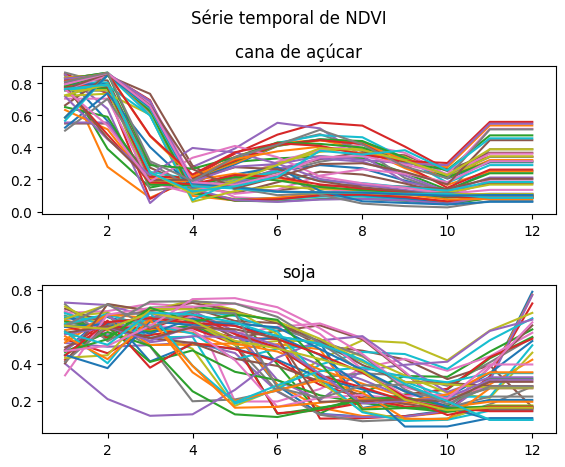

In [217]:
import matplotlib.pyplot as plt
#Plot NDVI time series for each crop

fig, axs = plt.subplots(2)
fig.tight_layout(pad=3.0)
fig.suptitle('Série temporal de NDVI', y=1.02) 
axs[0].plot(df_final['month'], df_final.iloc[:, 1:51]); 
axs[0].set_title('cana de açúcar')
axs[1].plot(df_final['month'], df_final.iloc[:, 51:]);
axs[1].set_title('soja')

plt.show()

<Axes: xlabel='mês'>

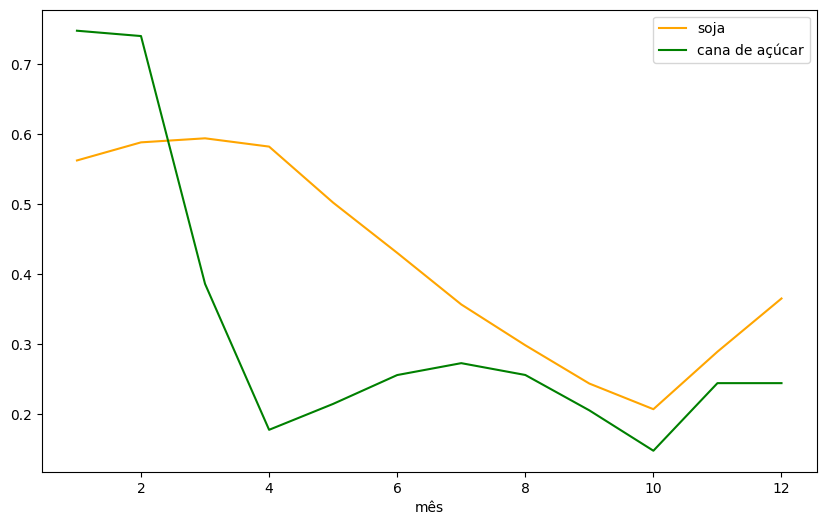

In [220]:
#get first 50 columns of df_final and compute the mean for each row
sugarcane = df_final.iloc[:, 1:51].mean(axis=1)
soybean = df_final.iloc[:, 51:].mean(axis=1)

#plot soybean and sugarcane in the same plot
df_output = pd.DataFrame(columns=['month'])
df_output['mês'] = range(1, 13)
df_output['soja'] = soybean
df_output['cana de açúcar'] = sugarcane

#set plot colors
colors = ['orange', 'green']

df_output.plot(x='mês', y=['soja', 'cana de açúcar'], figsize=(10, 6), color=colors)


#### 3. Train and predict with a machine learning model: Random Forest

In [ ]:
# Get label
#from json to dataframe
df = pd.DataFrame(data['features'])
df = df['properties'].apply(pd.Series)
#sort by id
df = df.sort_values('id')
df

In [128]:
df_final_T = df_final.T
#set month col to int
# reset index
df_final_T.columns = df_final_T.iloc[0]
df_final_T = df_final_T.drop('month')
df_final_T

#set column names to int
df_final_T.columns = df_final_T.columns.astype(int)
df_final_T = df_final_T.sort_index(axis=1)
df_final_T['target'] =  df['crop'].values
df_final_T


month,1,2,3,4,5,6,7,8,9,10,11,12,target
ndvi_1,0.845745,0.564477,0.202048,0.135616,0.165335,0.252960,0.289035,0.269352,0.192596,0.130137,0.250996,0.250996,1
ndvi_2,0.853356,0.278147,0.085578,0.201772,0.340284,0.425942,0.445872,0.391671,0.270389,0.166419,0.250718,0.250718,1
ndvi_3,0.832020,0.389953,0.149192,0.200414,0.309037,0.331038,0.343086,0.331368,0.240767,0.134672,0.238368,0.238368,1
ndvi_4,0.859986,0.733709,0.078589,0.216805,0.360972,0.478965,0.553830,0.535126,0.404569,0.261729,0.341407,0.341407,1
ndvi_5,0.854229,0.639449,0.052957,0.277678,0.392988,0.552665,0.518022,0.346620,0.185146,0.130337,0.173374,0.173374,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ndvi_96,0.568005,0.603871,0.538512,0.598270,0.587144,0.538534,0.195735,0.202021,0.207698,0.198756,0.303896,0.303896,0
ndvi_97,0.469450,0.498483,0.604999,0.749618,0.755098,0.706052,0.592534,0.453501,0.275161,0.212669,0.397128,0.397128,0
ndvi_98,0.608037,0.722439,0.594115,0.681553,0.672764,0.271936,0.215432,0.284241,0.288062,0.182715,0.278902,0.278902,0
ndvi_99,0.605968,0.588867,0.676257,0.633629,0.524732,0.483331,0.426719,0.362061,0.207174,0.150601,0.163977,0.163977,0


In [174]:
# Save final dataframe to csv
df_final_T.to_csv('../output/ndvi.csv', sep=';', index=True)

In [223]:
# Based on df_final_T, we can create a model to predict the crop type based on the NDVI values
# For example, we can use a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df_final_T.drop('target', axis=1)
y = df_final_T['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)


0.975

In [224]:
#in the random forest apply k-fold cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()


0.95

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.96      0.98        23

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40

Feature ranking:
1. feature 4 (0.21430638359374493)
2. feature 2 (0.18649986854508166)
3. feature 1 (0.17401977318633588)
4. feature 5 (0.12440856911801208)
5. feature 3 (0.10941630232667908)
6. feature 10 (0.04915846014524708)
7. feature 11 (0.03982367611759974)
8. feature 12 (0.034491399203755546)
9. feature 6 (0.019924211513148514)
10. feature 7 (0.017964835737729334)
11. feature 9 (0.016162938577643417)
12. feature 8 (0.013823581935022767)


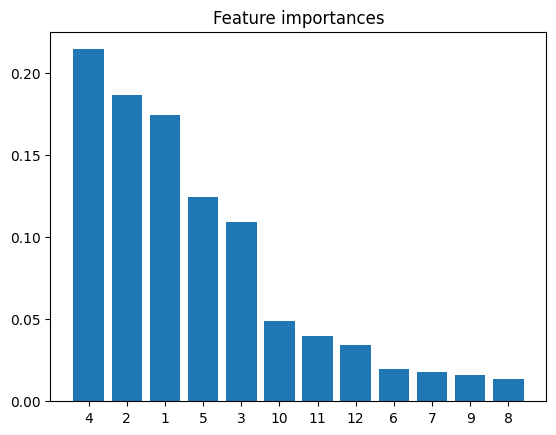

4

In [225]:
# Give accuracy metrics for prediction on test
from sklearn.metrics import classification_report
import numpy as np 
print(classification_report(y_test, y_pred))

# Get feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {features[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), indices+1)
plt.xlim([-1, X.shape[1]])
plt.show()

# Get the most important feature
most_important_feature = features[indices[0]]
most_important_feature


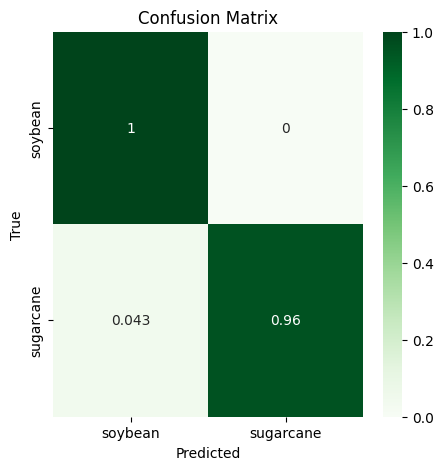

In [226]:
#create a nice confusion matrix with seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

crop_names = ['soybean', 'sugarcane']
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap='Greens', xticklabels=crop_names, yticklabels=crop_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### 4. Train and predict with a deep learning model: Linear model

Epoch 1/100
2/2 [==============================] - 1s 139ms/step - loss: 0.6828 - accuracy: 0.7167 - val_loss: 0.6833 - val_accuracy: 0.6750
Epoch 2/100
2/2 [==============================] - 0s 26ms/step - loss: 0.6802 - accuracy: 0.7833 - val_loss: 0.6816 - val_accuracy: 0.6750
Epoch 3/100
2/2 [==============================] - 0s 26ms/step - loss: 0.6776 - accuracy: 0.7833 - val_loss: 0.6800 - val_accuracy: 0.6750
Epoch 4/100
2/2 [==============================] - 0s 58ms/step - loss: 0.6751 - accuracy: 0.7667 - val_loss: 0.6784 - val_accuracy: 0.6500
Epoch 5/100
2/2 [==============================] - 0s 31ms/step - loss: 0.6731 - accuracy: 0.7500 - val_loss: 0.6771 - val_accuracy: 0.6250
Epoch 6/100
2/2 [==============================] - 0s 29ms/step - loss: 0.6712 - accuracy: 0.7333 - val_loss: 0.6760 - val_accuracy: 0.6000
Epoch 7/100
2/2 [==============================] - 0s 27ms/step - loss: 0.6694 - accuracy: 0.6833 - val_loss: 0.6749 - val_accuracy: 0.5500
Epoch 8/100
2/2 [==

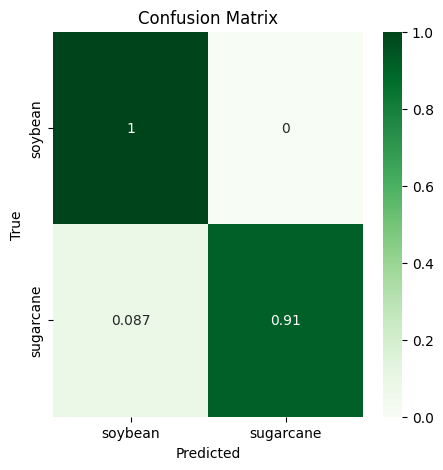

In [232]:
# Apply a deep learning model to predict the crop type based on the NDVI values
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Encode the target variable
encoder = LabelEncoder()
encoder.fit(y) # Fit the encoder to the target variable
encoded_Y = encoder.transform(y)
dummy_y = to_categorical(encoded_Y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.4, random_state=42)

# Create the model
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.000075), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")

# Get the predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# Get the classification report
print(classification_report(y_test, y_pred))

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

crop_names = ['soybean', 'sugarcane']
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap='Greens', xticklabels=crop_names, yticklabels=crop_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### 5. Train and predict with a unsupervised: K-means

c:\Users\tdu\.conda\envs\gdal_env\envs\tcc_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\tdu\.conda\envs\gdal_env\envs\tcc_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.67      0.92      0.77        50
           1       0.87      0.54      0.67        50

    accuracy                           0.73       100
   macro avg       0.77      0.73      0.72       100
weighted avg       0.77      0.73      0.72       100



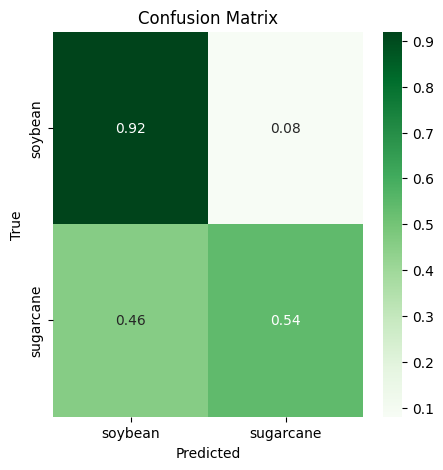

In [221]:
# Train and predict using k-means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)
y_pred = kmeans.predict(X_scaled)

# Get the classification report
print(classification_report(encoded_Y, y_pred))

# Get the confusion matrix
cm = confusion_matrix(encoded_Y, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#plt.figure(figsize=(5, 5))
#sns.heatmap(cm, annot=True, cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.title('Confusion Matrix')
#plt.show()

crop_names = ['soybean', 'sugarcane']
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap='Greens', xticklabels=crop_names, yticklabels=crop_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()